In [30]:
from ipynb.fs.full.Preprocessing import ReturnData,getData
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [31]:
allData = ReturnData()

TrainX = np.concatenate((allData[0][0],allData[1][0]),axis=0)
TrainY = np.concatenate((allData[0][1],allData[1][1]),axis=0)
TestX = allData[2][0]
TestY = allData[2][1]

The function PriorProbability calculates the Prior Probability of each possible target. In our case the possible targets are 0,1,2 and 3 respectively. 

In [32]:
start = time.time()
def PriorProbability(Targets):
    
    priors = []
    targets = np.unique(Targets)
    total = len(Targets)
    for t in targets:
        
        priors.append(len(np.where(np.asarray(Targets)==t)[0])/total)
    
    return priors

Priors  = PriorProbability(TrainY)

The function Likelihood calculates the likelihood table.<br>
However our representation of the likelihood table is quite different. <br>
We have multiple arrays which represent each feature. <br>
The rows of each matrix represent the value that the feature can take on and the columns represent the target values<br>
Example: Index[0][0] would represent the probability of a feature taking on value 0 and belonging to class/target 0<br>
Index[3][2] would represent the probability of a feature taking on the value 3 and belonging to class/target 2.<br>

Note that the dimensions of each array differ, since each feature has a different amount of possible values.<br>
Hence, the number of columns will always be the same , 4, but rows will differ.

In [33]:
def Likelihood(data,categories):
    
    likelihoods = []
    NumFeatures = np.shape(data)[1]
    targets = np.unique(categories)
    m = len(targets)
    
    for i in range(NumFeatures):
        feature = data[:,i]
        characteristics = np.unique(feature)
        n = len(characteristics)
        ll = np.empty((n,m))
        
        for j in range(m):
            t = targets[j]
            indices = np.where(np.asarray(categories)==t)
            data_of_target = feature[indices]
            
            for k in range(n):
                probability =(1 +len(np.where(np.asarray(data_of_target)==characteristics[k])[0]))/(len(indices[0])+6)
                ll[k][j] = probability
        
        likelihoods.append(ll)
                
    return likelihoods
            
        
Likelihoods = Likelihood(TrainX,TrainY)

The function ClassProbability will calculate the probability of a datapoint belonging to each class push
it into a list and return that list.<br>


In [34]:
def ClassProbability(data,likelihoods,Prior):
    
    final = []
    n = len(data)
    for d in data:
        
        length = len(Prior)
        probs = []
        
        for i in range(length):
            probability = 1
            
            for j in range(len(likelihoods)):
                l = likelihoods[j]
                probability *= l[d[j]][i]
            
            probs.append(probability)
            
        final.append(probs)
        
    return final

ClassProbs = ClassProbability(TestX,Likelihoods,Priors)

The function Predict will calculate the probability P(C|x) for each datapoint x and class C.<br>
It then takes the index of the maximum value of these probabilities and pushes it into a list which will contain all the classes the model predicts the datapoints belong to and return that list.<br>
We take the index since if it belongs to class 0, index 0 will have the largest value and so on so forth for the
other classes.

In [35]:
def Predict(Probs,Priors):
    ans = []
    
    for i in range(len(Probs)):
        p = []
        
        for j in range(4):
            n = Probs[i][j]*Priors[j]
            d = np.sum(np.asarray(Probs[i])*np.asarray(Priors))
            p.append(n/d)

        ans.append(p.index(max(p)))
    
    return ans

predictions = Predict(ClassProbs,Priors)

The result from Predict() an our actual targets can be used to compute our performance metrics.

In [36]:
TrainClassProbs = ClassProbability(TrainX,Likelihoods,Priors)
TrainPrediction = Predict(TrainClassProbs,Priors)
end = time.time()
print("The Training Confusion Matrix is:\n",metrics.confusion_matrix(TrainY.astype('int'),TrainPrediction),"\n")
print("The Training Accuracy is:",metrics.accuracy_score(TrainY.astype('int'),TrainPrediction)*100,"%\n")
print("The Training Precision is:",metrics.precision_score(TrainY.astype('int'),TrainPrediction,average=None),"\n")
print("The Training Recall is:",metrics.recall_score(TrainY.astype('int'),TrainPrediction,average = None),"\n")
print("The Time taken is:",end-start)

The Training Confusion Matrix is:
 [[940  29   0   0]
 [ 87 214   5   0]
 [  0  43  12   1]
 [  0  33   0  19]] 

The Training Accuracy is: 85.68329718004338 %

The Training Precision is: [0.91528724 0.67084639 0.70588235 0.95      ] 

The Training Recall is: [0.97007224 0.69934641 0.21428571 0.36538462] 

The Time taken is: 0.13513469696044922


In [37]:
print("The Test Confusion Matrix is:\n",metrics.confusion_matrix(TestY.astype('int'),predictions),"\n")
print("The Test Accuracy is:",metrics.accuracy_score(TestY.astype('int'),predictions)*100,"%\n")
print("The Testing Precision is:",metrics.precision_score(TestY.astype('int'),predictions,average=None),"\n")
print("The Testing Recall is:",metrics.recall_score(TestY.astype('int'),predictions,average = None))

The Test Confusion Matrix is:
 [[239   2   0   0]
 [ 20  56   2   0]
 [  0  10   3   0]
 [  0   9   0   4]] 

The Test Accuracy is: 87.53623188405797 %

The Testing Precision is: [0.92277992 0.72727273 0.6        1.        ] 

The Testing Recall is: [0.99170124 0.71794872 0.23076923 0.30769231]


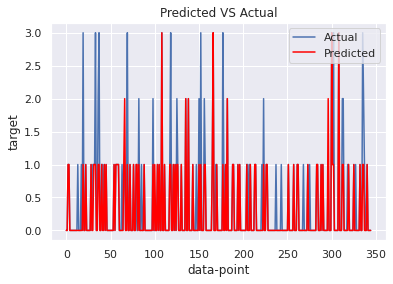

In [38]:
plt.plot(np.arange(len(TestY)),TestY,label = "Actual")
plt.plot(np.arange(len(TestY)),predictions,label = "Predicted",color="red")
plt.xlabel("data-point")
plt.ylabel("target")
plt.title("Predicted VS Actual")
plt.legend(loc = 'upper right')
plt.show()
plt.close()